## Imports

In [1]:
import sys
from multiprocessing import Pool

import arviz as az
import corner
import matplotlib.pyplot as plt
import numpy as np
from numba import njit, prange
from arviz.labels import MapLabeller
from eryn.ensemble import EnsembleSampler
from eryn.moves import (
    CombineMove,
    DistributionGenerateRJ,
    GaussianMove,
    MTDistGenMoveRJ,
    StretchMove,
)
from eryn.prior import ProbDistContainer
from eryn.state import State
from eryn.utils import TransformContainer
from eryn.utils.utility import groups_from_inds
from scipy.stats import invgamma, norm, uniform
from sklearn.model_selection import KFold, train_test_split

sys.path.append("../../TFM/rk-bfr")
seed = 42
rng = np.random.default_rng(seed)
np.random.seed(seed)

import utils.simulation_utils as simulation
from utils import plot_utils

%matplotlib inline

## Dataset

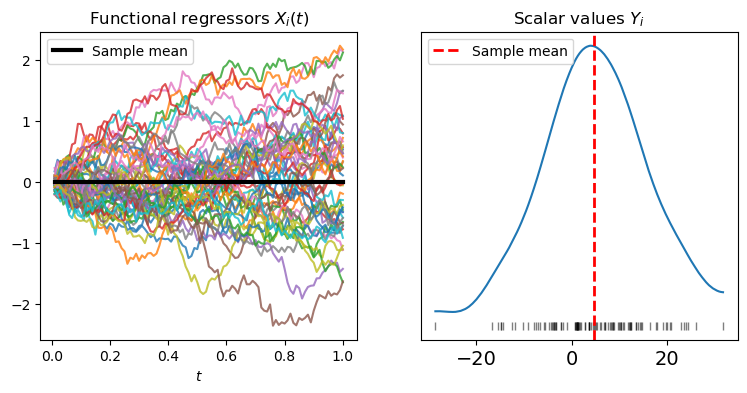

In [2]:
# define true parameters
component_params = np.array(
    [
        [-5, 0.1],
        [5, 0.6],
        [10, 0.8],
    ]
)
alpha0 = 5
sigma2 = 0.5

# define dataset parameters
ngrid = 100
n_train, n_test = 100, 50
mean_vector = np.zeros(ngrid)
kernel_fn = simulation.brownian_kernel

# generate regressors and response
t = np.linspace(1.0 / ngrid, 1, ngrid)
x = simulation.gp(t, mean_vector, kernel_fn, n_train + n_test, rng=rng)
y = simulation.generate_rkhs_dataset(
    x, t, component_params.T[0], component_params.T[1], alpha0, sigma2, rng=rng
)
y_noiseless = simulation.generate_rkhs_dataset(
    x, t, component_params.T[0], component_params.T[1], alpha0, 0.0, rng=rng
)

# Train/test split and standardize
indices = np.arange(n_train + n_test)  # for future convenience
X, X_test, Y, Y_test, idx_train, idx_test = train_test_split(
    x, y, indices, train_size=n_train, random_state=seed
)
X, X_test = simulation.standardize_predictors(X, X_test)
# Y, Y_test = simulation.standardize_response(Y, Y_test)

# Plot dataset
plot_utils.plot_dataset_regression(
    X,
    Y,
    n_samples=n_train // 2,
)

## Model RKHS

### Likelihood

In [10]:
class RKHSLikelihood:
    def __init__(self, t, X, y):
        self.t = t
        self.X_T = np.ascontiguousarray(X.T)
        self.y = y
        self.n = X.shape[0]

    # METHOD 1: Sequential computation for future parallelization with pool argument in Eryn
    def evaluate_sequential(self, theta):
        """Computes the log-likelihood log P(Y1,...,Y_n|theta, X_1, ..., X_n) for a single walker.

        - theta is a list [theta_components, theta_common] that represent the parameters for a single walker.
            * theta_components is an array (p, 2) of the parameters (b_j, t_j) for each component (leaf), where 1<=p<=p_max.
              In other words, on each call to this function the shape varies according to how many leaves are active.
            * theta_common is an array (1, 2) of the parameters alpha_0 and sigma^2, which are common for all models (leaves).
        - t is the discretized grid of shape (ngrid,)
        - X, y are the data, of shape (nfunc, ngrid) and (nfunc,) respectively.

        ========
        Return: the log-likelihood for the walker, i.e., log P(Y|theta, X).

        ========
        Note: Eryn already checks that the theta input values are valid (i.e. within the bounds of the prior).
        """
        theta_components, theta_common = theta
        beta = np.ascontiguousarray(theta_components[:, 0])
        tau = np.ascontiguousarray(theta_components[:, 1:2])
        alpha0 = theta_common[0][0]
        sigma2 = theta_common[0][1]

        # Compute the indices of the grid corresponding to the parameter tau
        idx_tau = np.abs(self.t - tau).argmin(axis=1)

        diff = self.y - alpha0 - self.X_T[idx_tau].T @ beta
        ll = -self.n * np.log(np.sqrt(sigma2)) - 0.5 * (diff @ diff) / sigma2

        return ll

    # Method 2: Vectorized computation with parallel execution of inner loop
    def evaluate_vectorized(self, theta, groups):
        """Computes the log-likelihood log P(Y_1,...,Y_n|[Theta], X_1, ..., X_n) for all walkers and temps.

        - theta is a list [theta_components, theta_common] that represents the parameters for _all_ walkers (across
          all temperatures).
            * theta_components is an array (N, 2) of the parameters (b_j, t_j) for all walkers and temps. N is the total
              number of active parameters in the RJ branch, i.e., N=sum(inds["components"]). Informally, we can
              compute N as nwalkers*ntemps*(active leaves on each (nwalker, ntemp)). In these arrays we have no
              information about which walker the parameters belong to; we just know their values.
            * theta_common is an array (M, 2) of the parameters alpha_0 and sigma^2 for all walkers and temps. M is
              the total number of such parameters (which is fixed), i.e., M=nwalkers*ntemps. In general, N >= M.
        - groups is a list [groups_components, groups_common] that represents the correspondence between parameters
          in the flattened array theta_* and the specific walker they belong to. Each group_* array contains integers,
          and each position within them represents the walker #id of the corresponding parameter in the same position
          on the theta_* array of parameters. The range of possible values is {1, 2, ..., M}. Eryn internally converts
          the inds array to groups information (eryn.utils.groups_from_inds), so that only active parameters are
          considered for the likelihood computation.
            * groups_components is an array (N,).
            * groups_common is an array (M,), and since the corresponding parameters are fixed and nleaves_min=1 in this
              branch, groups_common=np.arange(M). This parameter can be safely ignored.
        - t is the grid of shape (ngrid,)
        - X, y are the data, of shape (nfunc, ngrid) and (nfunc,) respectively.

        ========
        Example: suppose ntemps=2, nwalkers=2, and on each of the 4 total walkers we have 1, 2, 3 and 2 components active,
                 respectively. Then, N=1+2+3+2=8, while M=2*2=4. We would have groups_components = [0,1,1,2,2,2,3,3]
                 and groups_common = [0,1,2,3]. To compute the likelihood for walker i, we have to collect all theta_components
                 corresponding to this walker #id (whose indices are given by np.where(groups_components == i)), as well as
                 the corresponding alpha_0 and sigma^2 (theta_common[i]), and perform the computation per the model.

        ========
        Return: array (M,) in which each position is the log-likelihood for a specific walker, i.e.,
                log P(Y|Theta_i, X) (i=1,...,M).

        ========
        Note: Eryn already checks that the theta input values are valid (i.e. within the bounds of the prior).
        """
        theta_components, theta_common = theta
        groups_components, _ = groups

        beta = np.ascontiguousarray(theta_components[:, 0])
        tau = np.ascontiguousarray(theta_components[:, 1:2])
        alpha0 = np.ascontiguousarray(theta_common[:, 0])
        sigma2 = np.ascontiguousarray(theta_common[:, 1])

        idx_tau = np.abs(self.t - tau).argmin(axis=1)
        unique_indices = np.unique(groups_components)

        ll = self._compute_ll_parallel(
            groups_components,
            unique_indices,
            beta,
            idx_tau,
            alpha0,
            sigma2,
            self.X_T,
            self.y,
            self.n,
        )

        return ll

    # Actual parallel computation of log_likelihood for all groups
    @staticmethod
    @njit(
        "float64[::1](int64[::1], int64[::1], float64[::1], int64[::1], "
        "float64[::1], float64[::1], float64[:, ::1], float64[::1], int64)",
        parallel=True,
        fastmath=True,
        cache=True,
    )
    def _compute_ll_parallel(
        groups_components: np.ndarray,
        unique_indices: np.ndarray,
        beta: np.ndarray,
        idx_tau: np.ndarray,
        alpha0: np.ndarray,
        sigma2: np.ndarray,
        X_T: np.ndarray,
        y: np.ndarray,
        n: np.ndarray,
    ) -> np.ndarray:
        # Preallocate memory
        ll = np.empty_like(unique_indices, dtype=np.float64)  
        X_tau_masked = np.empty_like(X_T[0])
        beta_masked = np.empty_like(beta[0])
        diff = np.empty_like(y)
        
        for i in prange(len(unique_indices)):
            idx = unique_indices[i]
            mask = np.where(groups_components == idx)
            X_tau_masked = np.ascontiguousarray(X_T[idx_tau[mask]])
            beta_masked = beta[mask]
            alpha0_masked = alpha0[idx]
            sigma2_masked = sigma2[idx]
            log_sigma_masked = np.log(np.sqrt(sigma2_masked))

            diff = y - alpha0_masked - np.dot(X_tau_masked.T, beta_masked)
            ll[i] = -n*log_sigma_masked - 0.5 * np.dot(diff, diff) / sigma2_masked

        return ll

In [110]:
# large example (with timing)
import time
from functools import partial
from tqdm import tqdm
np.random.seed(42)

# Problem size
nreps = 10
nwalkers = 10000
nleaf = 10
ndim = 2
njobs = 4

print(f"Experiment with {nwalkers} walkers and {nleaf} leaves...")

times = np.zeros((nreps, 2))
ll = RKHSLikelihood(t, X, Y)
for rep in tqdm(range(nreps), desc="reps"):
    # Setup
    inds = np.random.randint(low=0, high=2, size=(nwalkers, nleaf), dtype=bool)
    idx = np.where(np.sum(inds, axis=-1) == 0)
    inds[*idx, 0] = True
    coords_comp = np.zeros((nwalkers, nleaf, ndim))
    coords_common = np.zeros((nwalkers, 1, ndim))
    for i in range(nwalkers):
        coords_comp[i] = np.random.rand(nleaf, ndim)
        coords_common[i] = np.random.rand(1, ndim)
    
    ## method A
    theta_lst = [[coords_comp[i][inds[i]], coords_common[i]] for i in range(nwalkers)]
    
    start = time.time()
    with Pool(njobs) as pool:
        resAA = pool.map(ll.evaluate_sequential, theta_lst)
    time_ll = time.time() - start
    
    ## method B
    groups = [
        np.arange(nwalkers)[:, None]
        for _ in range(2)
    ]
    groups[0] = np.repeat(groups[0], nleaf, axis=-1)[inds]

    # Generate a random permutation of indices
    random_indices = np.random.permutation(len(groups[0]))
    groups[0] = groups[0][random_indices]
    coords_comp_groups = coords_comp[inds][random_indices]
    coords_common_groups = coords_common.reshape(-1, 2)

    # Get likelihood object
    start = time.time()
    resBB = ll.evaluate_vectorized([coords_comp_groups, coords_common_groups], groups)
    time_ll_vectorized = time.time() - start
    
    assert np.allclose(resAA, resBB)

    times[rep, 0] = time_ll
    times[rep, 1] = time_ll_vectorized

mean_times = np.mean(times[nreps//10:, :], axis=0)
std_times = np.std(times[nreps//10:, :], axis=0)
print(f"Mean time log_likelihood: {mean_times[0]:.3f}±{std_times[0]:.3f}s")
print(f"Mean time log_likelihood_vectorized: {mean_times[1]:.3f}±{std_times[1]:.3f}s")
print(f"Mean speedup of vectorized vs. parallel: {mean_times[0]/mean_times[1]:.2f}x")

Experiment with 10000 walkers and 10 leaves...


reps: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]

Mean time log_likelihood: 0.141±0.006s
Mean time log_likelihood_vectorized: 0.109±0.014s
Mean speedup of vectorized vs. parallel: 1.29x


In [109]:
# simple example
bt1 = np.array([[1, 0.01], [2, 0.02]])  # walker #0, 2 components
bt2 = np.array([[10, 0.1], [20, 0.2], [30, 0.3]]) # walker #1, 3 components
a1 = 4.
a2 = 40.
s1 = 5.
s2 = 50.

## method A
th1 = [bt1, np.array([a1, s1]).reshape(1, 2)]
th2 = [bt2, np.array([a2, s2]).reshape(1, 2)]
resA = [ll.evaluate_sequential(theta) for theta in [th1, th2]]

## method B
th12 = [np.vstack((bt1, bt2)), np.vstack((np.array([a1, s1]), np.array([a2, s2])))]
groups12 = [np.array([0, 0, 1, 1, 1]), np.array([0, 1])]
resB = ll.evaluate_vectorized(th12, groups12)

assert np.allclose(resA, resB)

### Prior

**TODO prior**

1. Prior multivariante en beta FOR ALL LEAVES (parámetro especial prior_all_models). 
2. Prior en los beta y en sigma2 escalado según los datos. ¿CÓMO?
3. Prior de Grollemund et al. en alpha0: N(0, 100 * Y.mean()**2 * sigma2)

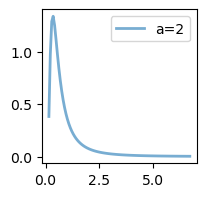

In [126]:
aa = 2
plt.figure(figsize=(2, 2))
x = np.linspace(invgamma.ppf(0.01, aa), invgamma.ppf(0.99, aa), 100)
plt.plot(x, invgamma.pdf(x, aa), lw=2, alpha=0.6, label=f"a={aa}")
_ = plt.legend()

In [113]:
np.random.seed(42)

# set coordinates for the leaf values in both branches
coords = {
    branch: np.zeros((ntemps, nwalkers, nleaf, ndim))
    for nleaf, ndim, branch in zip(nleaves_max.values(), ndims.values(), branch_names)
}

# sample initial values for components (b,t) and alpha0 from prior
coords["components"] = priors["components"].rvs(
    size=(ntemps, nwalkers, nleaves_max["components"])
)
coords["common"][:, :, 0, 0] = priors["common"].priors[0][1].rvs(size=(ntemps, nwalkers))

# sample initial values for sigma2 from inverse-gamma distribution
sigma2_param = 2
coords["common"][:, :, 0, 1] = invgamma(sigma2_param).rvs(size=(ntemps, nwalkers))

# set indices for used/unused leaves of components (boolean 0/1)
# we need to ensure that not all components are zero on any (ntemp,nwalkers),
# because nleaves_min = 1
inds = {}
inds["components"] = np.random.randint(
    2, size=(ntemps, nwalkers, nleaves_max["components"]), dtype=bool
)
idx = np.where(np.sum(inds["components"], axis=-1) == 0)
inds["components"][*idx, 0] = True

# set indices for the single leaf of [alpha0,sigma2] (always used because nleaves_min=1)
inds["common"] = np.ones((ntemps, nwalkers, nleaves_max["common"]), dtype=bool)

In [114]:
class jeffreys_prior:
    """Jeffrey's prior P(sigma2) ∝ 1/sigma2. It is equivalent to flat prior on log(sigma)"""
    
    def logpdf(self, x):
        """It receives an array (N,) of samples. It must check the bounds and return an array
        (N,) with -np.inf in positions of invalid values."""
        res = np.full_like(x, -np.inf)
        idx_valid = np.where(x > 0)  # identify samples where sigma2 > 0
        res[idx_valid] = -np.log(x[idx_valid])  # log P(sigma2) ∝ -log(sigma2)
        return res

class flat_prior:
    def logpdf(self, x):
        return 0

def uniform_dist(a, b):
    """Wrapper around scipy.stats.uniform; similar to eryn.prior.uniform_dist, but without
       the error that it needs floating numbers as input to logpdf or else it fails."""
    return uniform(loc=a, scale=b-a)
        
# describes priors for all leaves independently on each branch
# the prior on p (the number of components) is assumed to be uniform in [n_leaves_min,n_leaves_max]
priors = {
    "components": ProbDistContainer(
        {
            0: uniform_dist(-50, 50),  # beta
            1: uniform_dist(t.min(), t.max()),  # tau
        }
    ),
    "common": ProbDistContainer(
        {
            0: norm(0, 10*Y.mean()),  # alpha0
            1: jeffreys_prior(),  # P(sigma2) ∝ 1/sigma2
        }
    ),
}


class RKHSPrior():
    def __init__(self, t_min, t_max, Y_mean):
        self.t_min = t_min
        self.t_max = t_max
        self.Y_mean = Y_mean

    def logpdf(self, coords, inds):
        p_alpha0 = norm(0, 10*self.Y_mean)
        p_sigma2 = jeffreys_prior()
        p_beta = uniform_dist(-50, 50)
        p_tau = uniform_dist(self.t_min, self.t_max)


        lp_alpha0 = p_alpha0.logpdf(coords["common"][..., 0])[...,0]  # (ntemps, nwalkers)
        lp_sigma2 = p_sigma2.logpdf(coords["common"][..., 1])[...,0] # (ntemps, nwalkers)
        lp_beta = p_beta.logpdf(coords["components"][..., 0])  # (ntemps, nwalkers, nleaves_max)
        lp_tau = p_tau.logpdf(coords["components"][..., 1])  # (ntemps, nwalkers, nleaves_max)

        lp_beta[~inds["components"]] = 0.0
        lp_tau[~inds["components"]] = 0.0

        return lp_alpha0 + lp_sigma2 + lp_beta.sum(axis=-1) + lp_tau.sum(axis=-1)


priors_alt = {"all_models_together": RKHSPrior(t.min(), t.max(), Y.mean())}

In [115]:
lp1 = ensemble.compute_log_prior(coords, inds=inds)
lp2 = priors_alt["all_models_together"].logpdf(coords, inds)
assert np.allclose(lp1, lp2)

## Sampler

**TODO sampler**

Add transformation so that 1) we sample log_sigma instead of sigma2, and 2) the components are ordered. Maybe we have to
implement a custom RJMove class so that the births maintain the order.

1. Scale of ball around the estimate Y.mean() depends on the data. Same problem as with the prior above.
2. Tune parameters of moves on-the-fly? For example, use eryn.utils.AdjustStretchProposalScale update function to tune the stretch move.
   DOES THIS APPLY to the GroupStretch move (??)
4. GroupStretchMove (does this use the ensemble capabilities?).
5. Check acceptance rate and use it to select optimal scaling parameters on the moves (far from 0 and 1)
6. RJMCMC move (?) --> sample from conditional distribution on the rest of the parameters.
7. Multiple Try RJMCMC --> num_try?
8. Label switching (?)
9. Fine-grained control of gibbs_sampling_setup so that not all leaves/parameters are updated at one (see tutorial->Moves->Gibbs)
10. Stopping function when convergence is reached (?)

In [49]:
# set up chain parameters
branch_names = ["components", "common"]
nleaves_max = {"components": 5, "common": 1}
nleaves_min = {"components": 1, "common": 1}
ndims = {"components": 2, "common": 2}
nwalkers = 32
ntemps = 5

# set coordinates for the leaf values in both branches
coords = {
    branch: np.zeros((ntemps, nwalkers, nleaf, ndim))
    for nleaf, ndim, branch in zip(nleaves_max.values(), ndims.values(), branch_names)
}

# sample initial values for components (b,t) and alpha0 from prior
coords["components"] = priors["components"].rvs(
    size=(ntemps, nwalkers, nleaves_max["components"])
)
coords["common"][:, :, 0, 0] = priors["common"].priors[0][1].rvs(size=(ntemps, nwalkers))

# sample initial values for sigma2 from inverse-gamma distribution
sigma2_param = 2
coords["common"][:, :, 0, 1] = invgamma(sigma2_param).rvs(size=(ntemps, nwalkers))

# set indices for used/unused leaves of components (boolean 0/1)
# we need to ensure that not all components are zero on any (ntemp,nwalkers),
# because nleaves_min = 1
inds = {}
inds["components"] = np.random.randint(
    2, size=(ntemps, nwalkers, nleaves_max["components"]), dtype=bool
)
idx = np.where(np.sum(inds["components"], axis=-1) == 0)
inds["components"][*idx, 0] = True

# set indices for the single leaf of [alpha0,sigma2] (always used because nleaves_min=1)
inds["common"] = np.ones((ntemps, nwalkers, nleaves_max["common"]), dtype=bool)

`vectorize=True` seems to be slightly faster for smaller cases, but in general parallel sampling with a suitably chosen `n_jobs` value (generally 4, but also 2 or 8) performs better.

In [50]:
# number of steps
nsteps = 1
thin_by = 1
burn = 10

# number of cores
njobs = 4
vectorize = True

# moves
factor = 0.0001
cov = {branch: np.diag(np.ones(ndims[branch])) * factor for branch in branch_names}
move_gaussian = GaussianMove(cov)

move_stretch = StretchMove()

# rj moves
num_try = 2
rjmoveMT = MTDistGenMoveRJ(  # multiple-try distgen from prior
    {"components": priors["components"]},
    nleaves_max={
        branch: value for branch, value in zip(branch_names, nleaves_max.values())
    },
    nleaves_min={
        branch: value for branch, value in zip(branch_names, nleaves_min.values())
    },
    gibbs_sampling_setup="components",  # only perform RJ on the components
    num_try=num_try,
    rj=True,
)

rjmove = DistributionGenerateRJ(  # distgen from prior
    {"components": priors["components"]},
    nleaves_max={
        branch: value for branch, value in zip(branch_names, nleaves_max.values())
    },
    nleaves_min={
        branch: value for branch, value in zip(branch_names, nleaves_min.values())
    },
    gibbs_sampling_setup="components",  # only perform RJ on the components
)

# log_likelihood object
ll = RKHSLikelihood(t, X, Y)

# re-set random seed for reproducible sampling
np.random.seed(42)

# sample
with Pool(njobs) as pool:
    ensemble = EnsembleSampler(
        nwalkers,
        ndims,
        ll.evaluate_vectorized if vectorize else ll.evaluate_sequential,
        priors,
        pool=pool,
        vectorize=vectorize,
        provide_groups=vectorize,
        tempering_kwargs=dict(ntemps=ntemps),
        nbranches=len(branch_names),
        branch_names=branch_names,
        nleaves_max=nleaves_max,
        nleaves_min=nleaves_min,
        moves=move_stretch,
        rj_moves=rjmoveMT,
    )

    # setup starting state
    state = State(coords)

    # run the sampler
    print("Sampling posterior distribution...")
    last_sample = ensemble.run_mcmc(
        state, nsteps, burn=burn, progress=True, thin_by=thin_by
    )

Sampling posterior distribution...


100%|██████████| 1/1 [00:00<00:00, 49.01it/s]


## Analysis

In [32]:
lp = ensemble.backend.get_log_prior()
print(lp.shape)
lp

(1, 5, 32)


array([[[-23.0796732 , -15.71793178, -18.93848571, -28.85956247,
         -20.02154614, -24.11382919, -14.70418413, -18.35157441,
         -27.91861488, -23.08579573, -24.84079809, -28.46668388,
         -14.87990319, -19.20817947, -19.67519405, -19.52613133,
         -29.26114994, -15.86042047, -23.51342026, -24.16127547,
         -19.88425452, -14.611872  , -24.44722332, -20.27073836,
          -9.4028117 , -29.97111041, -23.52633919, -14.14852161,
         -14.68000511, -23.72988493, -23.15315306, -18.98907054],
        [-18.85645601, -18.95563639, -18.79258488, -13.66842663,
         -23.31284802, -13.83023422, -18.66025779, -28.27266463,
         -18.44936772, -23.69805458, -22.81056502, -18.93927271,
         -23.06324765, -19.12416067, -18.58884103, -27.97254553,
         -18.68172394, -27.58425768, -22.76229528, -23.54403446,
         -14.51810908, -23.43517472, -23.54960895, -23.38102446,
         -23.42071406, -18.85107499, -17.85260751, -22.92864928,
         -13.97145004, -

In [22]:
### print(last_sample.branches["components"].nleaves)
print(last_sample.branches["components"].inds[0, 0, :])
print(last_sample.branches_coords["components"][0, 0, :])
print(last_sample.branches_coords["common"][0, 0, :])

[False  True False  True  True]
[[-0.17687547  0.21769101]
 [11.57167034  0.79579473]
 [ 0.50892043  0.3816239 ]
 [-4.13298795  0.09538113]
 [ 3.31927544  0.60420363]]
[[4.40672257 2.40032725]]


In [8]:
print("Acceptance % (T=1)\n", 100 * ensemble.acceptance_fraction[0])
print("RJ Acceptance % (T=1)\n", 100 * ensemble.rj_acceptance_fraction[0])

Acceptance % (T=1)
 [2.1 3.2 2.5 1.9 2.4 2.3 4.7 2.6 2.9 2.4 2.9 1.4 3.  3.4 2.8 2.1 2.6 1.8
 3.5 2.6 2.9 2.6 2.  2.7 3.3 2.3 1.7 2.9 1.4 1.8 2.3 1.5 2.3 2.8 3.3 2.5
 2.9 2.4 3.6 3.2 1.9 3.2 2.3 2.8 2.6 2.3 2.5 1.6 1.5 2.  3.7 4.9 2.9 2.4
 2.8 2.7 2.4 2.9 2.9 3.1 1.8 2.3 2.9 1.6]
RJ Acceptance % (T=1)
 [1.7 0.5 0.8 1.1 0.7 0.8 0.9 1.3 1.1 0.4 0.5 0.5 0.6 0.9 2.  1.  0.7 0.9
 1.3 0.2 0.9 1.2 0.9 0.2 0.7 0.8 1.3 0.8 0.9 0.4 0.6 0.8 1.2 0.4 1.2 0.8
 1.4 1.  0.9 0.5 0.4 0.7 1.  1.1 1.1 0.4 0.6 0.2 1.  1.8 0.6 1.3 1.  0.7
 0.8 1.6 0.8 1.  1.2 0.6 0.8 0.4 0.6 1.2]


Posterior distribution p|D of the number of components across all walkers


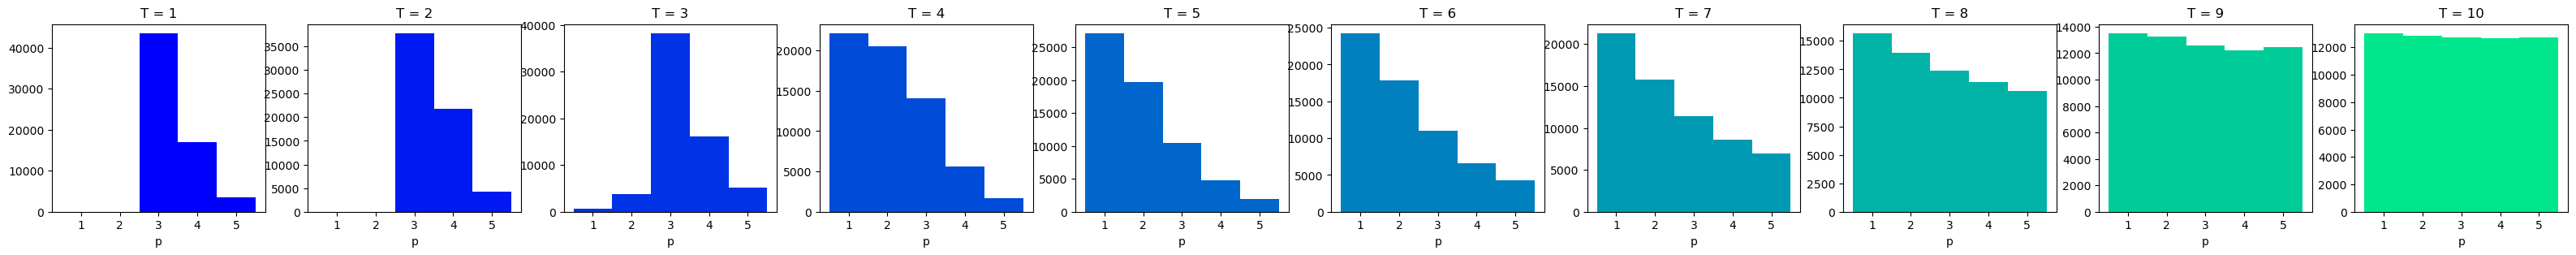

In [9]:
print("Posterior distribution p|D of the number of components across all walkers")

nleaves = ensemble.get_nleaves()["components"]
bins = np.arange(1, nleaves_max["components"] + 2) - 0.5
colors = plt.get_cmap("winter")

fig, ax = plt.subplots(1, ntemps, figsize=(4 * ntemps, 3))
for temp, ax_t in enumerate(ax):
    color = colors(temp / ntemps)
    ax_t.set_title("T = " + str(temp+1))
    ax_t.set_xlabel("p")
    ax_t.hist(nleaves[:, temp].flatten(), bins=bins, color=color)

Posterior distribution and trace across all walkers (T=1)
  * right now, we are only showing the first component (across the first walker)


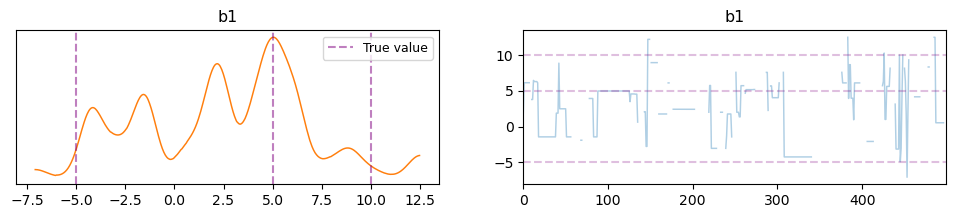

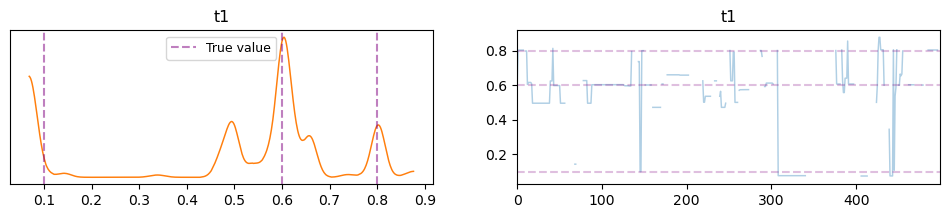

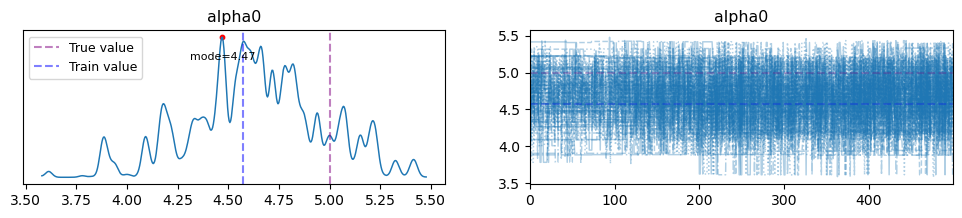

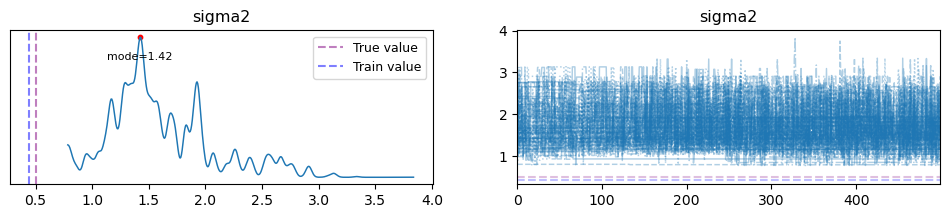

In [37]:
def plot_trace(
    chain_eryn,
    T=0,
    var_name="x",
    true_value=None,
    train_value=None,
    mode=False,
    az_kwargs={},
):
    # Get chain (nwalkers, nsamples)
    chain = np.atleast_2d(chain_eryn[:, T])
    if chain_eryn.ndim == 3:
        chain = chain.swapaxes(0, 1)

    # Plot marginal posterior and trace
    ax = az.plot_trace(
        chain, combined=True, labeller=MapLabeller({"x": var_name}), **az_kwargs
    )

    # Plot reference values
    handles = []
    if true_value is not None:
        true_value = np.atleast_1d(true_value)
        for i, value in enumerate(true_value):
            h = ax[0, 0].axvline(
                x=value, color="purple", linestyle="--", alpha=0.5, label="True value"
            )
            ax[0, 1].axhline(y=value, color="purple", linestyle="--", alpha=0.25)

            if i == 0:
                handles += [h]

    if train_value is not None:
        train_value = np.atleast_1d(train_value)
        for i, value in enumerate(train_value):
            h = ax[0, 0].axvline(
                x=value, color="b", linestyle="--", alpha=0.5, label="Train value"
            )
            ax[0, 1].axhline(y=value, color="b", linestyle="--", alpha=0.25)

            if i == 0:
                handles += [h]

    if mode:
        # Compute mode
        arr, density = az.kde(chain)
        idx_mode = np.argmax(density)
        mode = arr[idx_mode]

        ax[0, 0].text(
            mode,
            ax[0, 0].get_ylim()[1] * 0.8,
            f"mode={mode:.2f}",
            horizontalalignment="center",
            fontsize=8,
        )
        ax[0, 0].scatter(mode, density[idx_mode], color="red", s=10)
        
    if true_value is not None or train_value is not None:
        ax[0, 0].legend(handles=handles, fontsize=9)


# Get chain from sampler
chain = ensemble.get_chain(discard=0)

components_all = chain["components"]
inds_components = ensemble.get_inds()["components"]
components = components_all[inds_components]  # same as components_all[~np.isnan]
b_all_models = components_all[..., 0, 1, 0]
t_all_models = components_all[..., 0, 1, 1]

common = chain["common"].squeeze()
alpha0_chain = common[..., 0]
sigma2_chain = common[..., 1]

# Plot trace
print("Posterior distribution and trace across all walkers (T=1)")
print(
    "  * right now, we are only showing the first component (across the first walker)"
)
plot_trace(
    b_all_models, 0, "b1", component_params[:, 0], az_kwargs={"chain_prop": "color"}
)
plot_trace(
    t_all_models, 0, "t1", component_params[:, 1], az_kwargs={"chain_prop": "color"}
)
plot_trace(alpha0_chain, 0, "alpha0", alpha0, Y.mean(), mode=True)
plot_trace(
    sigma2_chain,
    0,
    "sigma2",
    sigma2,
    np.var(y[idx_train] - y_noiseless[idx_train]),
    mode=True,
)

**TODO**: get_clean_chain_k y funciones similares en los tutoriales de Eryn